#####Import Packages

In [ ]:
# Common imports
import numpy as np
import os
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from pandas.plotting import scatter_matrix 
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# to make this notebook's output stable across runs
np.random.seed(40)

#import modin.pandas as pd #a faster version of pandas that runs on multiple cores
import seaborn as sns
import scipy as sp
from astropy.table import Table #to read the .FITS file
from tqdm.notebook import tqdm  
import plotly.express as px
import plotly.graph_objects as go
import timeit
num=0
from google.colab import drive
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
#pd.set_option('use_inf_as_na', True)
pd.set_option('display.max_columns', None, 'max_colwidth', None, 'display.expand_frame_repr', False,'display.max_rows', None) # print all columns in full, prevent line break # print all columns in full, prevent line break

###Optical Dataset
Cosmos dataset matched with VLA Radio data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# HOR (Herschel Optical Radio Counterparts)
from astropy.table import Table #to read the .FITS file

hor_5 = Table.read(f'/content/drive/MyDrive/Herschel/all_opitical_matched_to_radio.fits', format='fits').to_pandas()
hor_5.drop('col1',axis=1,inplace=True) #remove null columns
hor_5 = hor_5.rename(columns={'F_BLIND_MF_SPIRE_250': 'H_250_flux','F_BLIND_MF_SPIRE_350': 'H_350_flux','F_BLIND_MF_SPIRE_500': 'H_500_flux','flux_match':'Radio_flux'})
hor_5[100:102] #216 matches #contains NANs for Optical Data

,Id,alpha,delta,zBEST,type,zPDF,zPDF_l68,zPDF_u68,zMinChi2,chi2_best,zp_2,chi2_2,NbFilt,zq,chiq,modq,mods,chis,maskUVISTA,maskHSC,maskSCAM,mask,model,age,extinction,MFUV,MNUV,MU,MG,MR,MI,MZ,MY,MJ,MH,MK,mass_med,mass_med_min68,mass_med_max68,mass_best,...,sSFR_best,L_nu,L_r,L_k,Herschel_RA,Herschel_Dec,H_250_flux,FErr_BLIND_MF_SPIRE_250,H_350_flux,FErr_BLIND_MF_SPIRE_350,H_500_flux,FErr_BLIND_MF_SPIRE_500,r,P,RA_pix,Dec_pix,F_BLIND_pix_SPIRE_250,FErr_BLIND_pix_SPIRE_250,ID_match,Project_match,Time_match,RA,RA_ERR_match,DEC,DEC_ERR_match,Radio_flux,flux_err_match,RMS_match,SNR_match,NPIX_match,RES_match,Multi_match,GroupID_2,GroupSize_2,Separation_2,s,s_norm,GroupID,GroupSize,Separation
100,96.0,151.048569,1.39154,-99.0,0.0,1.6299,0.3901,2.1224,0.44639,0.073839,1.640000,2.992727e-01,6.0,1.19,0.270166,10027.0,-220.0,1.721648,1.0,0.0,1.0,1.0,11.0,5.000000e+07,0.3,-17.778521,-17.932961,-18.913280,-19.207939,-19.61754,-19.382971,-19.60166,-19.754459,-19.872160,-20.091440,-19.944010,9.07747,8.64546,9.50713,8.43983,...,-7.342,9.767,9.084,8.162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,<NA>,<NA>,NaN
101,97.0,151.028366,1.39154,-99.0,0.0,1.5375,1.4595,1.6285,1.52900,1.531507,-99.900002,2.500000e+08,7.0,1.59,0.971187,10001.0,-220.0,12.432300,1.0,0.0,1.0,1.0,2.0,1.139000e+09,0.0,-17.775530,-18.049000,-18.582279,-19.824850,-20.11932,-20.241791,-20.36006,-20.447670,-20.471569,-20.581841,-20.354549,9.31176,9.07253,9.49228,9.45579,...,-9.909,8.572,9.008,8.281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,<NA>,<NA>,NaN



*   Identify which optical sources have radio counterparts
*   Create new column displaying 'True' if there is a radio counterpart and 'False' if there is no counterpart.
*   Remove infinite values.
*   Drop radio fluxes.  

In [ ]:
hor_5['Radio_flux'].fillna(0,inplace=True)
hor_5['H_pair'] = np.where(hor_5['Radio_flux']!= 0, True, False)
hor_5 = hor_5.replace([999, -999], np.nan)
hor_5 = hor_5.dropna(subset=['MU'], how='all')
hor_5 = hor_5.drop(hor_5[hor_5.Radio_flux>6000].index)
print(hor_5.isnull().values.any())
hor_5.count()

True


Id                          1708369
alpha                       1708370
delta                       1708370
zBEST                       1708370
type                        1708370
zPDF                        1708370
zPDF_l68                    1693275
zPDF_u68                    1708367
zMinChi2                    1708370
chi2_best                   1708370
zp_2                        1708370
chi2_2                      1708370
NbFilt                      1708370
zq                          1708370
chiq                        1708370
modq                        1708370
mods                        1708370
chis                        1708370
maskUVISTA                  1708370
maskHSC                     1708370
maskSCAM                    1708370
mask                        1708370
model                       1708370
age                         1708370
extinction                  1708370
MFUV                        1705406
MNUV                        1705406
MU                          

'Herschel_RA', 'Herschel_Dec', 'F_BLIND_MF_SPIRE_250', 'FErr_BLIND_MF_SPIRE_250', 'F_BLIND_MF_SPIRE_350', 'FErr_BLIND_MF_SPIRE_350', 'F_BLIND_MF_SPIRE_500', 'FErr_BLIND_MF_SPIRE_500', 'r', 'P', 'RA_pix', 'Dec_pix', 'F_BLIND_pix_SPIRE_250', 'FErr_BLIND_pix_SPIRE_250', 'ID_match', 'Project_match', 'Time_match', 'RA', 'RA_ERR_match', 'DEC', 'DEC_ERR_match', 'flux_match', 'flux_err_match', 'RMS_match', 'SNR_match', 'NPIX_match', 'RES_match', 'Multi_match', 'GroupID_1', 'GroupSize_1', 'Separation_1', 's', 's_norm', 'Id', 'alpha', 'delta', 'zBEST', 'type', 'zPDF', 'zPDF_l68', 'zPDF_u68', 'zMinChi2', 'chi2_best', 'zp_2', 'chi2_2', 'NbFilt', 'zq', 'chiq', 'modq', 'mods', 'chis', 'maskUVISTA', 'maskHSC', 'maskSCAM', 'mask', 'model', 'age', 'extinction', 'MFUV', 'MNUV', 'MU', 'MG', 'MR', 'MI', 'MZ', 'MY', 'MJ', 'MH', 'MK', 'mass_med', 'mass_med_min68', 'mass_med_max68', 'mass_best', 'SFR_med', 'SFR_med_min68', 'SFR_med_max68', 'SFR_best', 'sSFR_med', 'sSFR_med_min68', 'sSFR_med_max68', 'sSFR_best', 'L_nu', 'L_r', 'L_k', 'GroupID', 'GroupSize', 'Separation']

In [ ]:
dftrue = hor_5[hor_5['H_pair'] == True]
dffalse = hor_5[hor_5['H_pair'] == False]
dftrue['H_pair'].count(),dffalse['H_pair'].count()

(1128, 1707242)

In [ ]:
dffalse1 = dffalse[:1132]
frames = [dftrue, dffalse1]
df1 = pd.concat(frames)
df1[1131:1133]

,Id,alpha,delta,zBEST,type,zPDF,zPDF_l68,zPDF_u68,zMinChi2,chi2_best,zp_2,chi2_2,NbFilt,zq,chiq,modq,mods,chis,maskUVISTA,maskHSC,maskSCAM,mask,model,age,extinction,MFUV,MNUV,MU,MG,MR,MI,MZ,MY,MJ,MH,MK,mass_med,mass_med_min68,mass_med_max68,mass_best,SFR_med,SFR_med_min68,SFR_med_max68,SFR_best,sSFR_med,sSFR_med_min68,sSFR_med_max68,sSFR_best,L_nu,L_r,L_k,Herschel_RA,Herschel_Dec,H_250_flux,FErr_BLIND_MF_SPIRE_250,H_350_flux,FErr_BLIND_MF_SPIRE_350,H_500_flux,FErr_BLIND_MF_SPIRE_500,r,P,RA_pix,Dec_pix,F_BLIND_pix_SPIRE_250,FErr_BLIND_pix_SPIRE_250,ID_match,Project_match,Time_match,RA,RA_ERR_match,DEC,DEC_ERR_match,Radio_flux,flux_err_match,RMS_match,SNR_match,NPIX_match,RES_match,Multi_match,GroupID_2,GroupSize_2,Separation_2,s,s_norm,GroupID,GroupSize,Separation,H_pair
9,5.0,149.540176,1.39154,-99.0,0.0,1.3280,1.0682,1.7022,1.3143,1.634610,0.83,1.680232,8.0,0.32,2.147980,10028.0,-1.0,1.515800,1.0,0.0,1.0,1.0,10.0,5.000000e+07,0.0,-17.386820,-16.613689,-17.89028,-16.774210,-16.775999,-16.31900,-16.29377,-16.257589,-16.166969,-16.093969,-15.73476,7.87928,7.44103,8.38222,6.92816,-0.56944,-0.69267,-0.28308,-0.41270,-8.39430,-8.96353,-7.89905,-7.341,8.242,7.562,6.428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
10,6.0,149.437347,1.39150,-99.0,0.0,1.5665,1.4465,1.6697,1.6026,8.536343,1.19,9.057786,10.0,2.18,21.792856,10030.0,-7.0,20.977875,1.0,0.0,1.0,1.0,10.0,1.800000e+09,0.0,-18.791611,-18.398951,-18.35935,-19.131269,-19.229321,-19.14599,-19.20454,-19.225620,-19.700090,-18.735741,-18.45912,8.69628,8.55840,8.79858,8.76267,-0.08600,-0.16407,-0.01291,-0.09184,-8.78495,-8.93104,-8.58912,-8.855,8.807,8.624,7.712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [ ]:
px.scatter(dftrue, x= 'H_250_flux', y = 'Radio_flux')

In [ ]:
#dftrue
px.histogram(dftrue, x= 'H_250_flux', nbins=200)

In [ ]:
dftrue['H_250_flux']

In [ ]:
sed = dftrue[['MFUV', 'MNUV', 'MU', 'MG', 'MR', 'MI', 'MZ', 'MY', 'MJ', 'MH', 'MK', 'H_500_flux','H_350_flux','H_250_flux','Radio_flux']] #Select features
sed['H_250_flux'] = sed['H_250_flux']*-300
sed['H_350_flux'] = sed['H_350_flux']*-300
sed['H_500_flux'] = sed['H_500_flux']*-300
sed['Radio_flux'] = sed['Radio_flux']*-1
sed.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

,MFUV,MNUV,MU,MG,MR,MI,MZ,MY,MJ,MH,MK,H_500_flux,H_350_flux,H_250_flux,Radio_flux
0,-17.77466,-19.436520,-21.391430,-22.697041,-23.37159,-23.491461,-23.81315,-24.02318,-24.398380,-24.66296,-24.517059,-7.730516,-12.085363,-10.966571,-46.400002
1,-18.73823,-19.602909,-21.118999,-22.096960,-22.71516,-22.999081,-23.26742,-23.47831,-23.666531,-24.06988,-24.015751,-4.416452,-4.178557,-6.394137,-24.200001


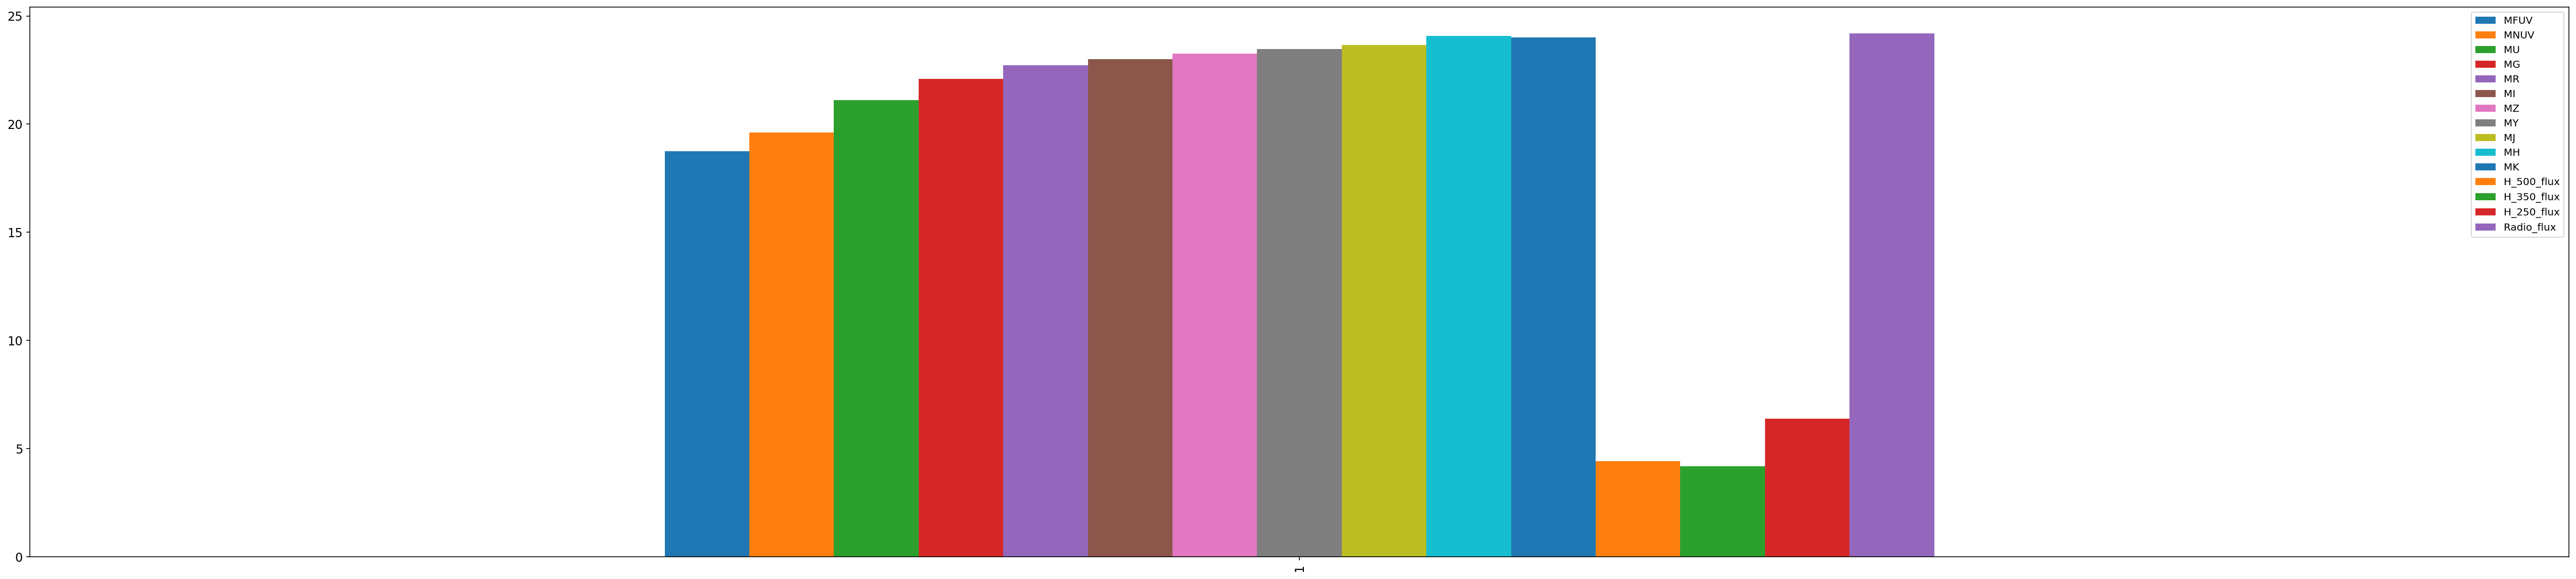

In [ ]:

num = sed[1:2]*-1
num.plot.bar(figsize=[45,10])
plt.show()


###SED

##ML Preprocessing 2

In [ ]:
dftrue = hor_5_SED[hor_5_SED['H_pair'] == True]
dffalse = hor_5_SED[hor_5_SED['H_pair'] == False]
dftrue['H_pair'].count(),dffalse['H_pair'].count()

NameError: ignored

1505 samples of 1132 go into 1704274
<br> create false dataset of length 1132

In [ ]:
dffalse1 = dffalse[:1132]
frames = [dftrue, dffalse1]
df1 = pd.concat(frames)
df1[1130:1134]

In [ ]:
df_x1 = df1.drop('H_pair',axis=1)
df_y1 = df1['H_pair']

#split the data into training and test data sets

train_x1, test_x1, train_y1, test_y1 = train_test_split(df_x1, df_y1, test_size=0.2, random_state=40,stratify=df_y1)
sns.countplot(df1['H_pair'])

##Train ML models

###Decision Tree 10%

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

tree=DecisionTreeClassifier(random_state=40,max_depth=10,max_leaf_nodes=25)
#Train and predict dataset to get scores
tree.fit(train_x1,train_y1)
y_pred1 = tree.predict(test_x1)

print(round(accuracy_score(test_y1, y_pred1),4))
print('     Neg   Pos')
print('Neg',confusion_matrix(test_y1,y_pred1))
print(classification_report(test_y1,y_pred1))

[201....17]<br>[27....208]

In [ ]:

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(tree, out_file='tree.dot', 
                feature_names = ['MFUV',	'MNUV',	'MU',	'MG',	'MR',	'MI',	'MZ',	'MY',	'MJ',	'MH',	'MK'],
                class_names = ['No Counterpart','True Counterpart'],
                rounded = True, proportion = False, 
                precision = int(2), filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display the tree
from IPython.display import Image
Image(filename = 'tree.png')

###Random Forest 10%

In [ ]:
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# define search space
space = dict(criterion = ['gini', 'entropy'],
         max_depth = randint(1, 100), 
         min_samples_split = randint(2, 15), 
         max_leaf_nodes = randint(5, 30))

# define DT classification model
model =RandomForestClassifier(random_state=40)

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='recall', n_jobs=-1, cv=cv, random_state=1)

# execute search
result1 = search.fit(train_x1, train_y1)
forest_y_pred1=search.predict(test_x1)

In [ ]:
# summarize result
print('Best Score: %s' % result1.best_score_)
print('Best Hyperparameters: %s' % result1.best_params_)
print(round(accuracy_score(test_y1, y_pred1),4),'\n')
print('     Neg   Pos')
print('Neg',confusion_matrix(test_y1,y_pred1))
print(classification_report(test_y1,y_pred1))

###LSTM Predictor 10%

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import r2_score
#train_x1, test_x1, train_y1, test_y1

lgb_train = lgb.Dataset(train_x1, train_y1)

lgb_eval = lgb.Dataset(test_x1, test_y1, reference=lgb_train)

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse"
}


gbm = lgb.train(params,
                train_set=lgb_train,
               
                num_boost_round=300,
                valid_sets=lgb_eval,
                early_stopping_rounds=150
                )

lstm_y_pred = gbm.predict(test_x1, num_iteration=gbm.best_iteration)

print('The rmse of prediction is:', mean_squared_error(test_y1, lstm_y_pred)**0.5)

In [ ]:
print('The rmse of prediction is:', mean_squared_error(test_y1, lstm_y_pred)**0.5)

In [ ]:
predict = lstm_y_pred
plt.hist(predict,bins=50)

###Neural networks

In [ ]:
features=['MFUV',	'MNUV',	'MU',	'MG',	'MR',	'MI',	'MZ',	'MY',	'MJ',	'MH',	'MK','H_pair']

In [ ]:
#train_x1, test_x1, train_y1, test_y1

model=keras.Sequential()

model.add(Dense(len(features[:-1]), kernel_initializer='normal',input_dim = train_x1.shape[1], activation='relu'))

# The Hidden Layers :
model.add(Dense(128, kernel_initializer='normal',activation='relu'))
model.add(Dropout(rate=0.5, noise_shape=None, seed=None))
model.add(Dense(256, kernel_initializer='normal',activation='softmax'))
model.add(Dropout(rate=0.5, noise_shape=None, seed=None))
model.add(Dense(128, kernel_initializer='normal',activation='relu'))

# The Output Layer :
model.add(Dense(1, kernel_initializer='normal',activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')

callbacks_list = [checkpoint]

model.fit(train_x1, train_y1, epochs=2000, batch_size=512, validation_split = 0.2, callbacks=callbacks_list)

#Relu_history=NN_model.fit(train_x1,train_y1,epochs=60,validation_split=0.1,callbacks=[early_stopping_cb])
#history = model.fit(x_train1, y_train1, epochs = 30, validation_split=0.1)
model.evaluate(test_x1, test_y1)

# Evaluate on test data
print('\n---- Test data ----')
predictions = model.predict(test_x1)
accuracy = sklearn.metrics.accuracy_score(test_y1, np.argmax(predictions, axis=1))
print('Accuracy: {0:.2f}%'.format(accuracy * 100.0))
print('Classification Report:')
print(sklearn.metrics.classification_report(test_y1, np.argmax(predictions, axis=1)))
print('Confusion Matrix:')
print(sklearn.metrics.confusion_matrix(test_y1, np.argmax(predictions, axis=1)))


Accuracy: 50.11%
Classification Report:
              precision    recall  f1-score   support

       False       0.50      1.00      0.67       227
        True       0.00      0.00      0.00       226

    accuracy                           0.50       453
   macro avg       0.25      0.50      0.33       453
weighted avg       0.25      0.50      0.33       453

Confusion Matrix:<br>
[227   0]<br>
 [226   0]

###NN

In [ ]:
features=['MFUV',	'MNUV',	'MU',	'MG',	'MR',	'MI',	'MZ',	'MY',	'MJ',	'MH',	'MK','H_pair']

In [ ]:
# define model #Reshape x input
model_nn = Sequential()
model_nn.add(Dense(len(features[:-1]), kernel_initializer='normal',input_dim = train_x1.shape[1], activation='relu'))
model_nn.add(Dense(100, input_dim=2, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))
model_nn.add(Dense(100, input_dim=2, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))
model_nn.add(Dense(300, input_dim=2, activation="relu"))   
model_nn.add(Dense(100,  input_dim=2,activation="relu"))
model_nn.add(Dense(1, activation='sigmoid'))
# compile model
model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit model
model_nn.fit(train_x1, train_y1, epochs=300, verbose=0)

In [ ]:
model_nn.summary()

In [ ]:
model_nn.evaluate(test_x1, test_y1)

# Evaluate on test data
print('\n---- Test data ----')
predictions1 = model_nn.predict(test_x1)
accuracy1 = accuracy_score(test_y1, np.argmax(predictions1, axis=1))
print('Accuracy: {0:.2f}%'.format(accuracy1 * 100.0))
print('Classification Report:')
print(classification_report(test_y1, np.argmax(predictions1, axis=1)))
print('Confusion Matrix:')
print(confusion_matrix(test_y1, np.argmax(predictions1, axis=1)))


In [ ]:
# predict probabilities for test set
yhat_probs = model_nn.predict(test_x1, verbose=0)
# predict crisp classes for test set
yhat_classes = model_nn.predict_classes(test_x1, verbose=0)
# predict probabilities for test set
yhat_probs = model_nn.predict(test_x1, verbose=0)
# predict crisp classes for test set
yhat_classes = model_nn.predict_classes(test_x1, verbose=0)

In [ ]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_y1, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_y1, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y1, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y1, yhat_classes)
print('F1 score: %f' % f1)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_y1, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_y1, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_y1, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_y1, yhat_classes)
print('F1 score: %f' % f1)

In [ ]:
# fit model #train_x1, test_x1, train_y1, test_y1
history = model_nn.fit(train_x1, train_y1, validation_data=(test_x1, test_y1), epochs=300, verbose=0)
# evaluate the model
_, train_acc = model_nn.evaluate(train_x1, train_y1, verbose=0)
_, test_acc = model_nn.evaluate(test_x1, test_y1, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

In [ ]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [ ]:
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

###Auto Machine Learning 
https://pypi.org/project/mljar-supervised/

In [ ]:
#!pip install mljar-supervised

In [ ]:
#pip install delayed

In [ ]:
from supervised.automl import AutoML

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [ ]:
automl = AutoML(explain_level=2, eval_metric = 'average_precision')
automl.fit(train_x1, train_y1)

predictions = automl.predict(test_x1)

AutoML directory: AutoML_1
The task is binary_classification with evaluation metric average_precision
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline average_precision 0.501104 trained in 0.55 seconds
2_DecisionTree average_precision 0.915976 trained in 14.91 seconds
3_Linear average_precision 0.963813 trained in 4.56 seconds
* Step default_algorithms will try to check up to 3 models


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:104: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:104: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



4_Default_Xgboost average_precision 0.965797 trained in 6.58 seconds
5_Default_NeuralNetwork average_precision 0.974079 trained in 2.23 seconds
6_Default_RandomForest average_precision 0.959722 trained in 8.68 seconds
* Step ensemble will try to check up to 1 model
Ensemble average_precision 0.976923 trained in 0.86 seconds


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



AutoML fit time: 55.75 seconds
AutoML best model: Ensemble


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:104: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



In [ ]:
print(predictions)
print("Test accuracy:", accuracy_score(test_y1, predictions))

[0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 1 0 0 1
 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1
 1 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 1 0
 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1
 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1
 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0
 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0
 1 1 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 1 0 1
 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0
 1 0 0 1 0 0 0 1 0]
Test accuracy: 0.9448123620309051


In [ ]:
print('   Neg',' Pos','\n',confusion_matrix(test_y1,predictions) )
print(classification_report(test_y1,predictions))

   Neg  Pos 
 [[209  18]
 [  7 219]]
              precision    recall  f1-score   support

       False       0.97      0.92      0.94       227
        True       0.92      0.97      0.95       226

    accuracy                           0.94       453
   macro avg       0.95      0.94      0.94       453
weighted avg       0.95      0.94      0.94       453



###ML model compete
https://supervised.mljar.com/features/explain/

Following Code runs for 10 minutes

In [ ]:
#auto_1 = AutoML( mode="Compete", explain_level=1, eval_metric = 'average_precision' )

#auto_1.fit(train_x1, train_y1)

NameError: ignored

In [ ]:
"""pred_1 = auto_explain.predict(test_x1)
print(pred_1)
print("Test accuracy:", accuracy_score(test_y1, pred_1))
print('   Neg',' Pos','\n',confusion_matrix(test_y1,pred_1) )
print(classification_report(test_y1,pred_1))"""

###Visualisation (Error)

In [ ]:
import sklearn
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from dtreeviz.models.sklearn_decision_trees import ShadowSKDTree

import graphviz
import pandas as pd
from dtreeviz.models.shadow_decision_tree import ShadowDecTree
from dtreeviz.models.sklearn_decision_trees import ShadowSKDTree
from dtreeviz import trees
from sklearn import tree

In [ ]:
features=['MFUV',	'MNUV',	'MU',	'MG',	'MR',	'MI',	'MZ',	'MY',	'MJ',	'MH',	'MK','H_pair']
target = "H_pair"
tree_classifier = DecisionTreeClassifier(max_depth=5, random_state=40)
tree_classifier.fit(df1[features], df1[target])
sk_dtree = ShadowSKDTree(tree_classifier, df1[features], df1[target], features, target, [0, 1])

In [ ]:
dataset=df1

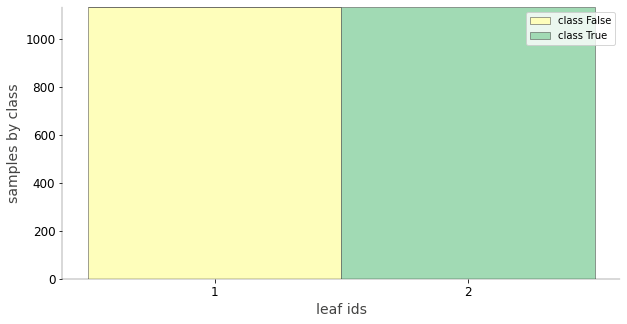

In [ ]:
trees.ctreeviz_leaf_samples(sk_dtree)

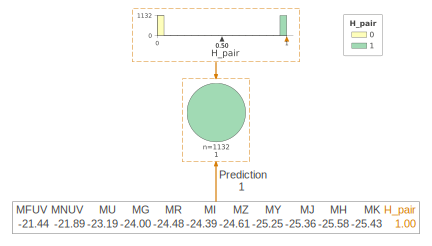

In [ ]:
trees.dtreeviz(sk_dtree, show_just_path=True, X = dataset[features].iloc[10])

In [ ]:
X = dataset[features].iloc[10]
X

MFUV      -21.43865
MNUV     -21.891319
MU        -23.18755
MG       -23.997789
MR        -24.47636
MI        -24.38695
MZ       -24.609051
MY        -25.25165
MJ        -25.36367
MH       -25.580379
MK       -25.429461
H_pair         True
Name: 6739, dtype: object

In [ ]:
print(trees.explain_prediction_path(tree_classifier, X, feature_names=features, explanation_type="plain_english"))

0.5 <= H_pair 



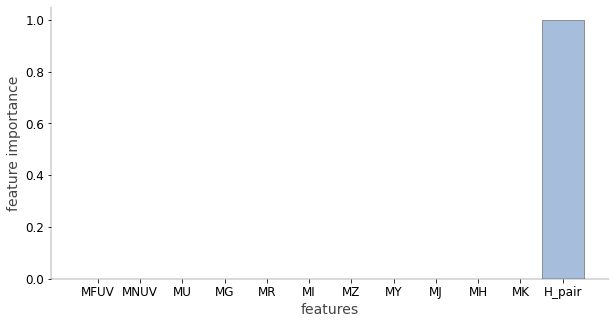

In [ ]:
trees.explain_prediction_path(tree_classifier, X, feature_names=features, explanation_type="sklearn_default")

In [ ]:
import sys
import os
# add library module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../")

import sklearn
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import xgboost as xgb
from xgboost import plot_importance, plot_tree, plotting

from dtreeviz import trees 

import graphviz
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

import pandas as pd
import numpy as np
from dtreeviz.models.shadow_decision_tree import ShadowDecTree
from dtreeviz.models.xgb_decision_tree import ShadowXGBDTree

In [ ]:
dtrain = xgb.DMatrix(dataset[features], dataset[target])
params = {"max_depth":3, "eta":0.05, "objective":"binary:logistic", "subsample":1}
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=8)

In [ ]:
X_reg = dataset[features].iloc[10]
X_reg

MFUV      -21.43865
MNUV     -21.891319
MU        -23.18755
MG       -23.997789
MR        -24.47636
MI        -24.38695
MZ       -24.609051
MY        -25.25165
MJ        -25.36367
MH       -25.580379
MK       -25.429461
H_pair         True
Name: 6739, dtype: object

###AutoML Explain 2

AutoML directory: AutoML_2
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Xgboost']
AutoML will ensemble availabe models


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



AutoML steps: ['simple_algorithms', 'default_algorithms', 'golden_features', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:104: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:104: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:104: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:104: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:104: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:104: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



1_Default_Xgboost logloss 0.183998 trained in 17.21 seconds
Skip golden_features because no parameters were generated.
* Step ensemble will try to check up to 1 model
AutoML fit time: 23.07 seconds
AutoML best model: 1_Default_Xgboost


AutoML(algorithms=['Xgboost'], explain_level=2, golden_features=True,
       total_time_limit=30,
       validation_strategy={'k_folds': 3, 'shuffle': False, 'stratify': True,
                            'validation_type': 'kfold'})

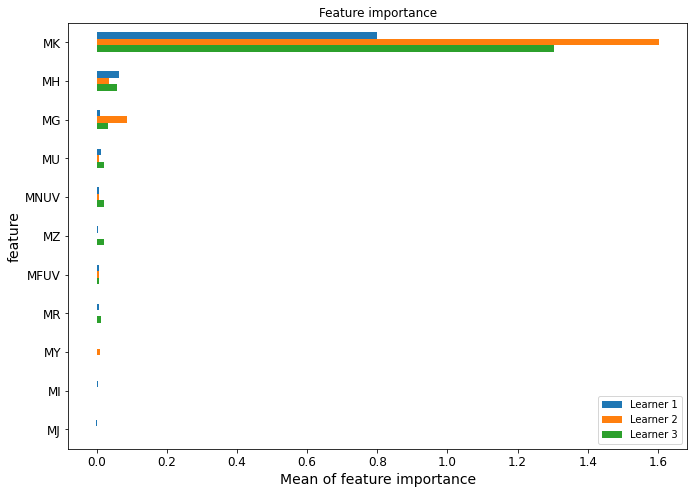

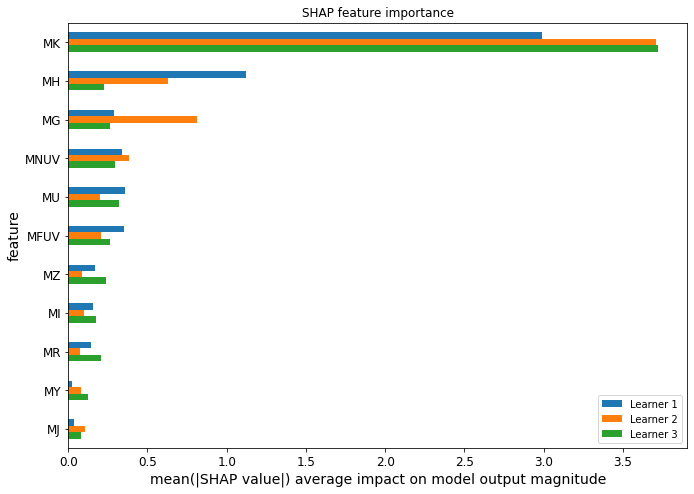

In [ ]:
a = AutoML(algorithms=['Xgboost'],total_time_limit=30,
           explain_level=2,golden_features=True,
           validation_strategy={
            "validation_type": "kfold",
            "k_folds": 3,
            "shuffle": False,
            "stratify": True,
            })
a.fit(train_x1,train_y1)

Available Algorithms ['Random Forest', 'Xgboost', 'Decision Tree', 'Baseline', 'LightGBM', 'Extra Trees', 'CatBoost', 'Linear', 'Neural Network', 'Nearest Neighbors']

AutoML directory: AutoML_11
The task is binary_classification with evaluation metric average_precision
AutoML will use algorithms: ['Neural Network']
AutoML will ensemble availabe models


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'golden_features', 'ensemble']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_NeuralNetwork average_precision 0.964004 trained in 5.88 seconds
Skip golden_features because no parameters were generated.
* Step ensemble will try to check up to 1 model
AutoML fit time: 11.53 seconds
AutoML best model: 1_Default_NeuralNetwork


AutoML(algorithms=['Neural Network'], eval_metric='average_precision',
       explain_level=2, golden_features=True, total_time_limit=30,
       validation_strategy={'k_folds': 3, 'shuffle': False, 'stratify': True,
                            'validation_type': 'kfold'})

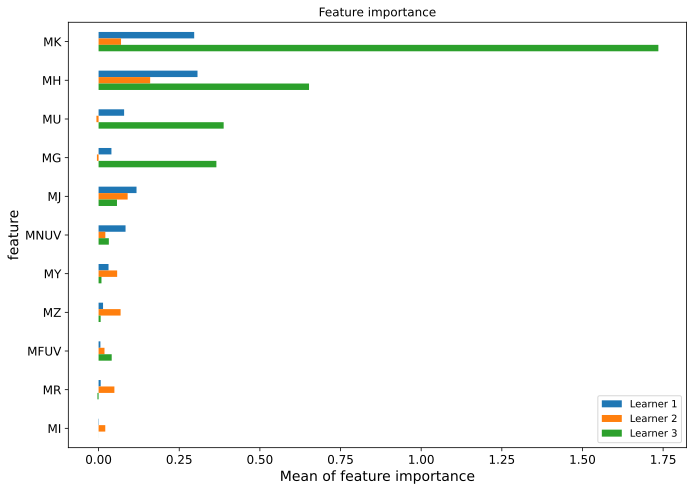

In [ ]:
b = AutoML(algorithms=['Neural Network'],
           total_time_limit=30,
           explain_level=2,golden_features=True,
           eval_metric = 'average_precision',
           validation_strategy={
            "validation_type": "kfold",
            "k_folds": 3,
            "shuffle": False,
            "stratify": True,
            })
b.fit(train_x1,train_y1)

##Descriptive Analysis

Data for cutoff at 5% of random data

In [ ]:
optical_5 = Table.read(f'Optical_Herschel_Radio_5_percent.fits', format='fits').to_pandas()
optical_5.drop('col1',axis=1,inplace=True) #remove null columns
optical_5[0:20] #216 matches #contains NANs for Optical Data

In [ ]:
optical_5['r'].count()

1244

In [ ]:
optical_5 = optical_5[optical_5['age'].notna()] #Removes optical data that contains an error
optical_5['r'].count()
# F_BLIND_MF_SPIRE_250 F_BLIND_MF_SPIRE_350 F_BLIND_MF_SPIRE_500 RA DEC flux_match s_norm zPDF age extinction MFUV	MNUV	MU	MG	MR	MI	MZ	MY	MJ	MH	MK

216

In [ ]:
optical_5 = optical_5.rename(columns={'F_BLIND_MF_SPIRE_250': 'H_250_flux','F_BLIND_MF_SPIRE_350': 'H_350_flux','F_BLIND_MF_SPIRE_500': 'H_500_flux','flux_match':'Radio_flux'})

In [ ]:
optical_5_2=optical_5[optical_5['zPDF']>0]
scatter_matrix(optical_5_2[['H_250_flux','ID_match','Radio_flux','s','zPDF']],figsize=(15, 15),hist_kwds={'bins':50},s=10)

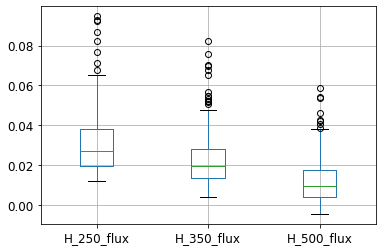

In [ ]:
optical_5[['H_250_flux','H_350_flux','H_500_flux']].boxplot()

####Histogram of all the features

ValueError: ignored

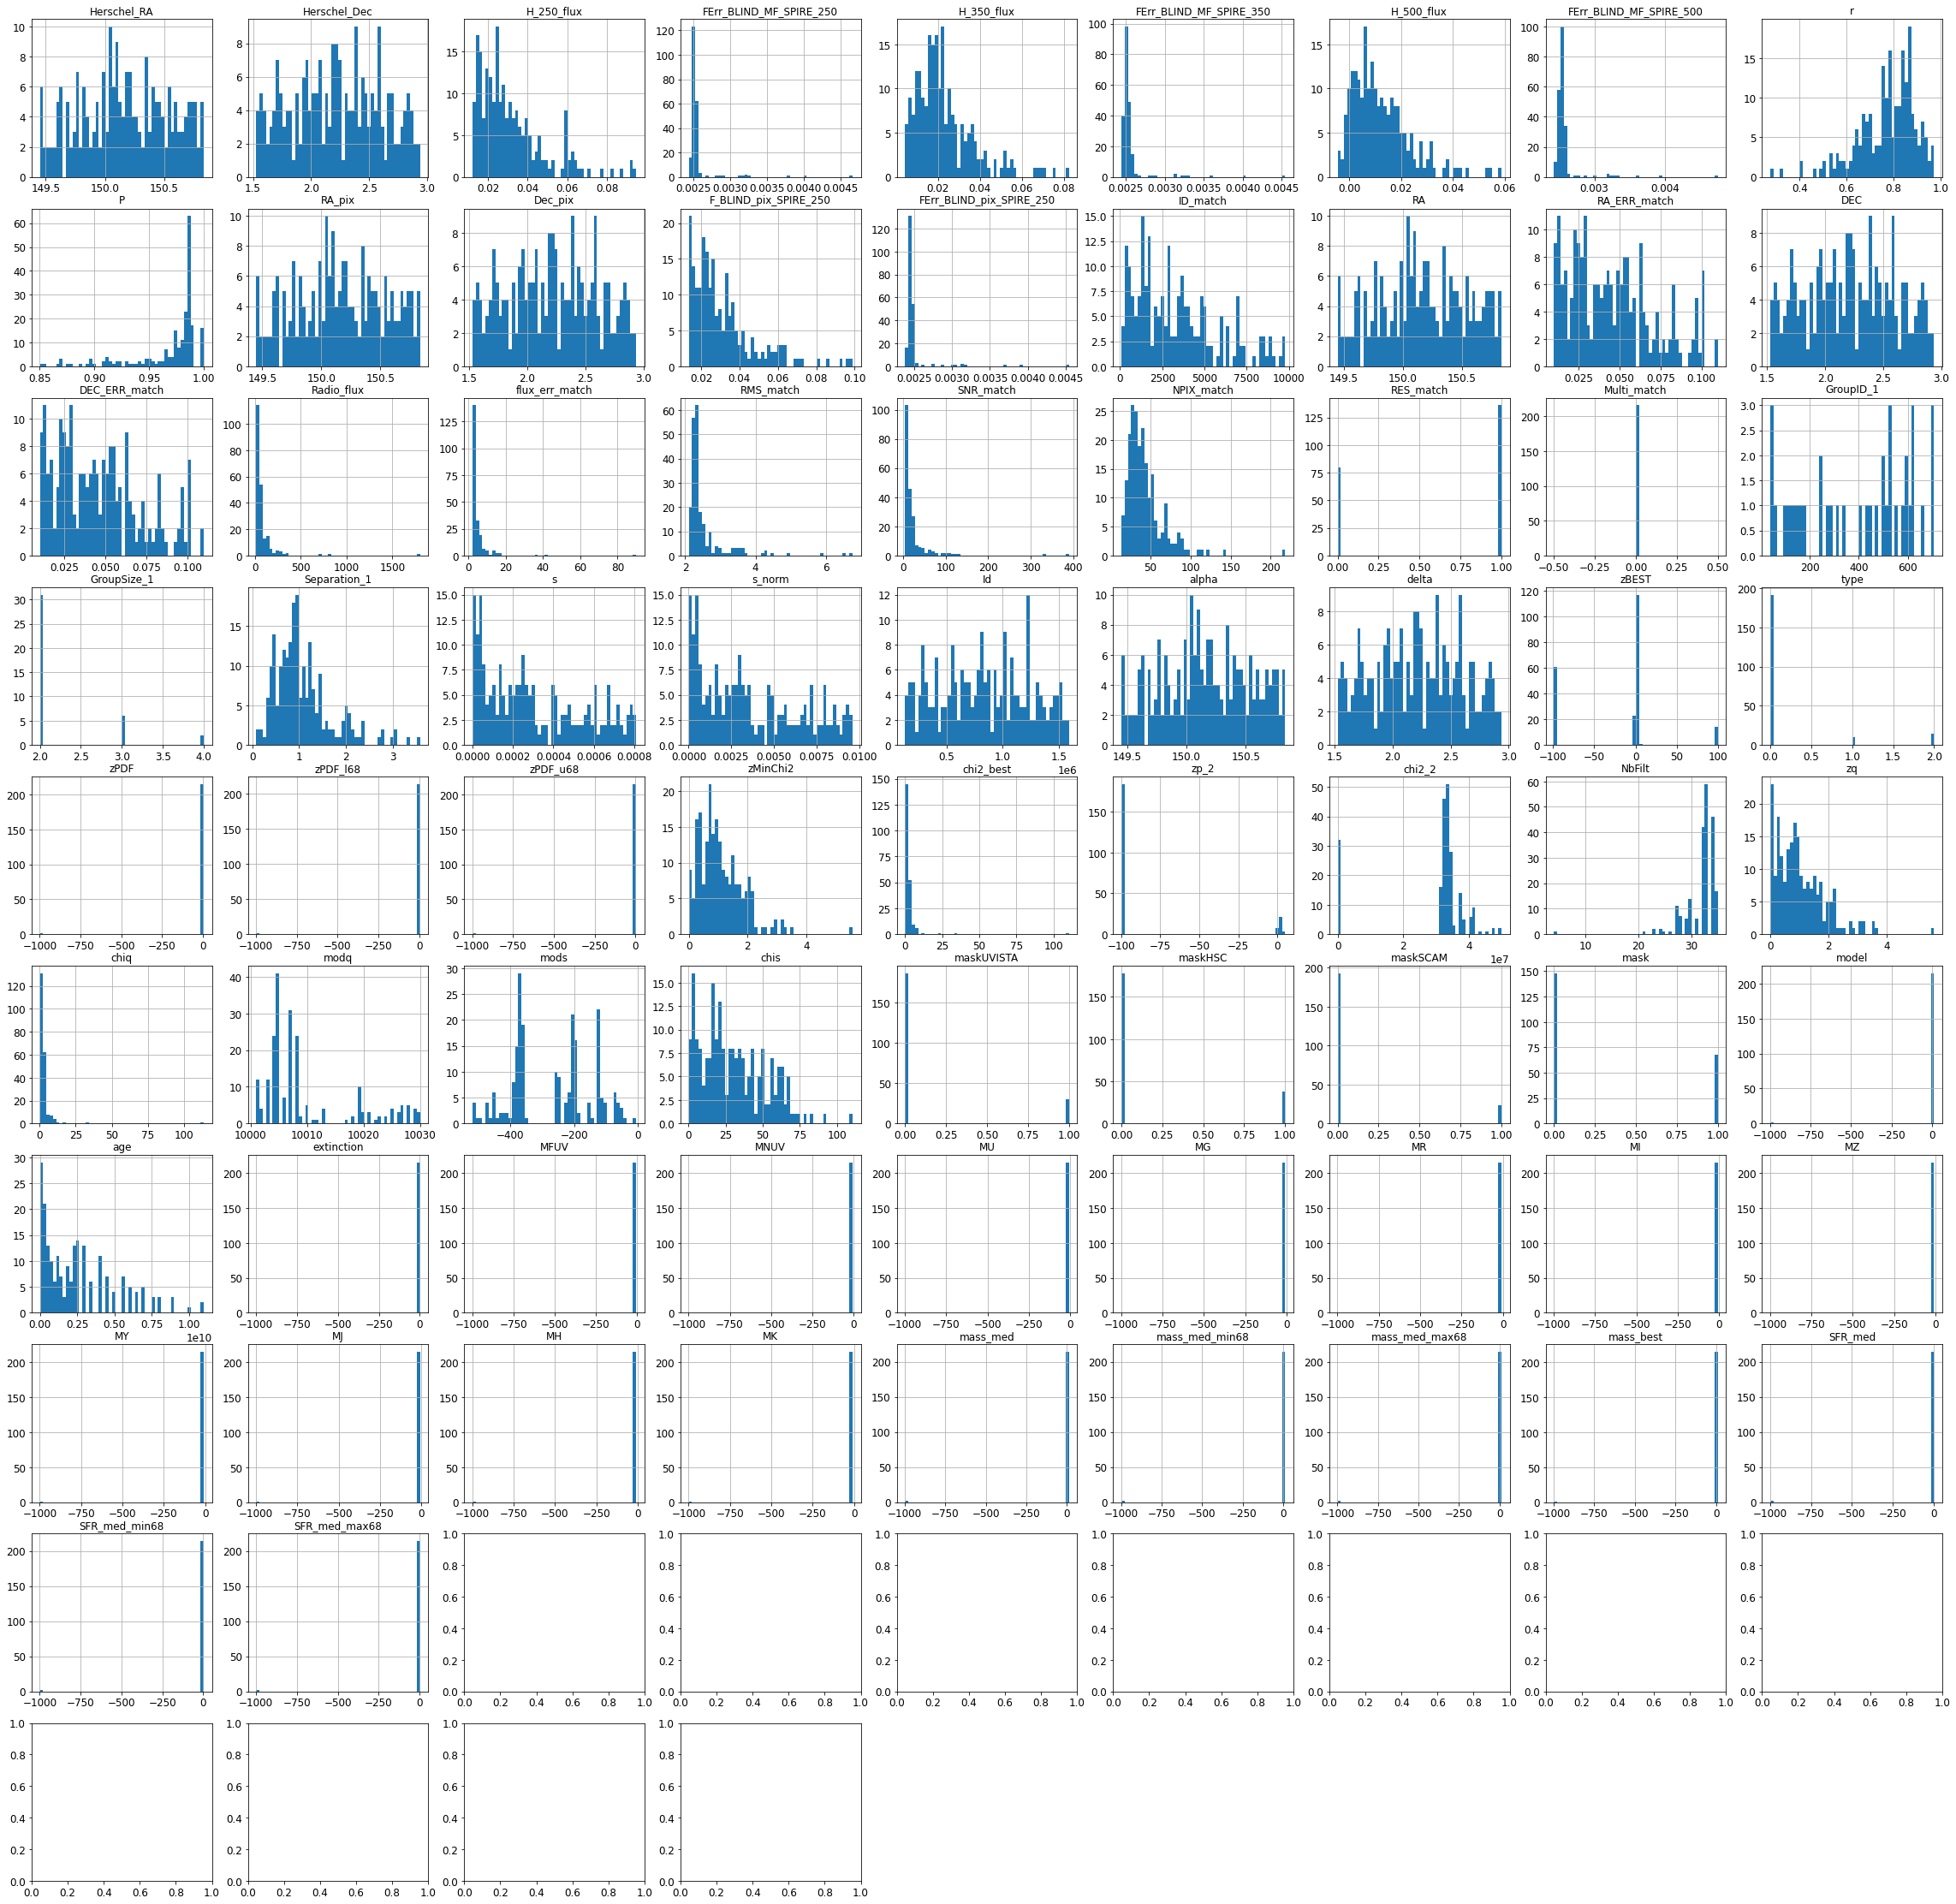

In [ ]:
#Code adapted from chapter 2 of Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition by Aurélien Géron 
optical_5.hist(bins=50, figsize=(40,40))
plt.show()

Separation seems to be cut off too low, possibly missing out real counterparts

In [ ]:
px.histogram(optical_5,x='Separation', nbins=50)

#####Inspect SFR_best

####Correlation between Features

In [ ]:
correlation  = optical_5[['H_250_flux','H_350_flux','H_500_flux','RA','DEC','Radio_flux','s_norm','zPDF','age','extinction','MFUV','MNUV','MU','MG','MR','MI','MZ','MY','MJ','MH','MK']]
corr_matrix = correlation.corr() #Correlation Matrix
print(corr_matrix)


            H_250_flux  H_350_flux  H_500_flux        RA       DEC  Radio_flux    s_norm      zPDF       age  extinction      MFUV      MNUV        MU        MG        MR        MI        MZ        MY        MJ        MH        MK
H_250_flux    1.000000    0.837547    0.595797 -0.005313 -0.086037    0.272298 -0.247191  0.060614 -0.025195    0.061778  0.056102  0.056466  0.056680  0.056533  0.056335  0.056531  0.056311  0.056011  0.055847  0.055490  0.055375
H_350_flux    0.837547    1.000000    0.894428 -0.004626 -0.026408    0.174027 -0.139914  0.005179 -0.141871    0.002895 -0.004384 -0.003641 -0.002637 -0.001951 -0.001805 -0.001239 -0.001202 -0.001368 -0.001315 -0.001399 -0.001244
H_500_flux    0.595797    0.894428    1.000000  0.014880  0.037934    0.110683 -0.097836 -0.064832 -0.212968   -0.069032 -0.076472 -0.075453 -0.073999 -0.072909 -0.072570 -0.071729 -0.071533 -0.071478 -0.071313 -0.071249 -0.070699
RA           -0.005313   -0.004626    0.014880  1.000000 -0.010582   -0.0243

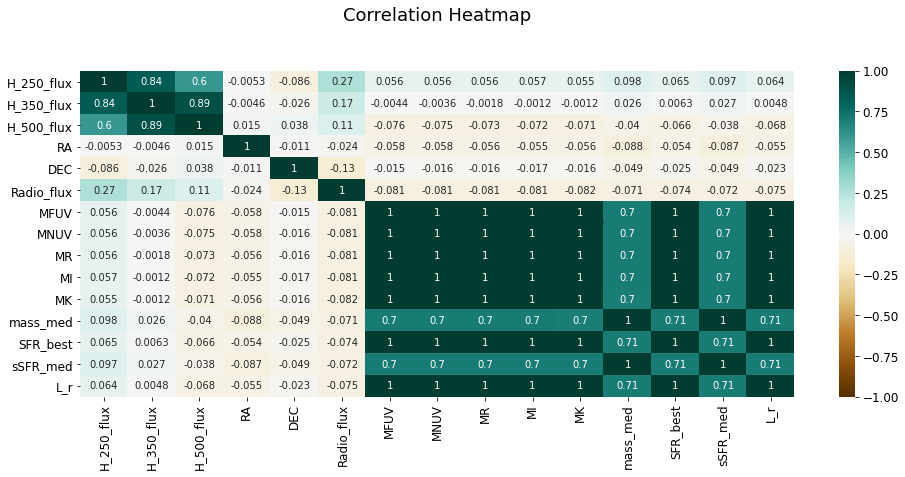

In [ ]:
df_corr = optical_5[['H_250_flux','H_350_flux','H_500_flux','RA','DEC','Radio_flux','MFUV','MNUV','MR','MI','MK','mass_med','SFR_best','sSFR_med','L_r']]

# code adapted from https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_corr.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=50);
#plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

####Histograms of key features

Star formation rate

In [ ]:
optical_5['SFR_best'].hist()

Age

In [ ]:
optical_5['age'].hist()

## Principal Component Analysis

Now do some analysis

Some principle component analysis to find any patterns

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt

[0.69065836 0.09196968 0.04640633 0.03908702 0.03586022]
0.9039815963069053


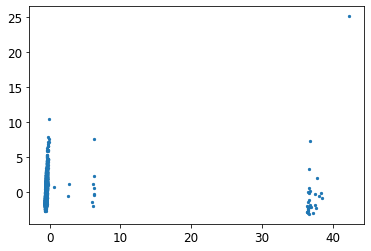

In [ ]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(train_x_enc)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principle component 3','principle component 4','principle component 5'])

plt.scatter(principalDf['principal component 1'],principalDf['principal component 2'],s=5)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

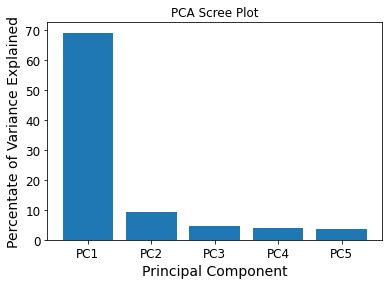

In [ ]:
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = ['PC1', 'PC2', 'PC3', 'PC4','PC5']
plt.bar(x= range(1,6), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

Index(['Herschel_RA', 'Herschel_Dec', 'F_BLIND_MF_SPIRE_250',
       'FErr_BLIND_MF_SPIRE_250', 'F_BLIND_MF_SPIRE_350',
       'FErr_BLIND_MF_SPIRE_350', 'F_BLIND_MF_SPIRE_500',
       'FErr_BLIND_MF_SPIRE_500', 'r', 'P', 'RA_pix', 'Dec_pix',
       'F_BLIND_pix_SPIRE_250', 'FErr_BLIND_pix_SPIRE_250', 'ID_match',
       'Project_match', 'Time_match', 'RA', 'RA_ERR_match', 'DEC',
       'DEC_ERR_match', 'flux_match', 'flux_err_match', 'RMS_match',
       'SNR_match', 'NPIX_match', 'RES_match', 'Multi_match', 'Separation_1',
       's', 's_norm', 'alpha', 'delta', 'zBEST', 'type', 'zPDF', 'zPDF_l68',
       'zPDF_u68', 'zMinChi2', 'chi2_best', 'zp_2', 'chi2_2', 'NbFilt', 'zq',
       'chiq', 'modq', 'mods', 'chis', 'maskUVISTA', 'maskHSC', 'maskSCAM',
       'mask', 'model', 'age', 'extinction', 'MFUV', 'MNUV', 'MU', 'MG', 'MR',
       'MI', 'MZ', 'MY', 'MJ', 'MH', 'MK', 'mass_med', 'mass_med_min68',
       'mass_med_max68', 'mass_best', 'SFR_med', 'SFR_med_min68',
       'SFR_med_max68'

,principal component 1,principal component 2,principle component 3,principle component 4,principle component 5,sSFR_best
0,-0.562821,-0.933613,1.201080,-0.941926,0.480554,-9.389
1,-0.534977,-1.197954,-0.556140,0.281092,0.014094,-10.730
2,-0.595613,-1.331954,0.800175,-0.852413,0.464433,NaN
3,-0.494172,-0.087535,1.563149,0.076730,-0.475692,NaN
4,-0.572762,-1.233368,0.288820,0.182936,-0.188281,NaN


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

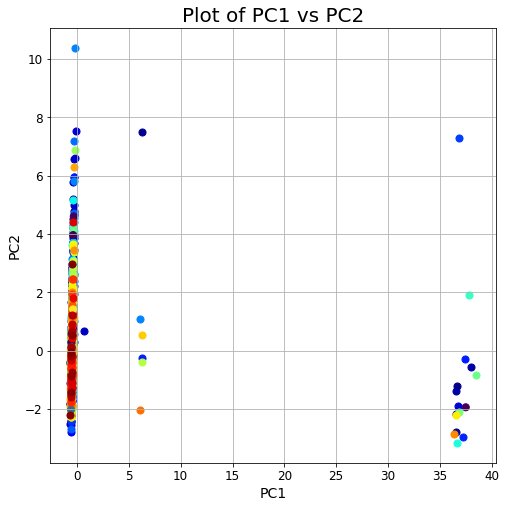

In [ ]:
print(train_x.columns)
finalDf = pd.concat([principalDf, train_x['sSFR_best']], axis = 1)
display(finalDf.head())
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax.set_title('Plot of PC1 vs PC2', fontsize = 20)

targets = train_x['sSFR_best'].unique()

colors = colors = plt.cm.jet(np.linspace(0,1,len(targets)))

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['sSFR_best'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
    
#ax.legend(targets)
ax.grid()